# Linear elasticity: unfitted boundary


In [29]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from ngsolve.webgui import * 
from xfem import *
import pyvista as pv
from IPython.display import Image, display

 Geometry & mesh (rectangle with named sides)

In [30]:
shape = Rectangle(1.0, 1.0).Face()
shape.edges.Max(X).name = "right"
shape.edges.Min(X).name = "left"
shape.edges.Max(Y).name = "top"
shape.edges.Min(Y).name = "bottom"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=0.025))

Material (E, nu)

In [31]:
levelset = (sqrt((x-0.5)**2+(y-0.5)**2) - (0.375))
DrawDC(levelset, -3.5, 2.5, mesh,"levelset")
vtk = VTKOutput(mesh, coefs=[levelset], names=["levelset"], filename="levelset").Do()

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

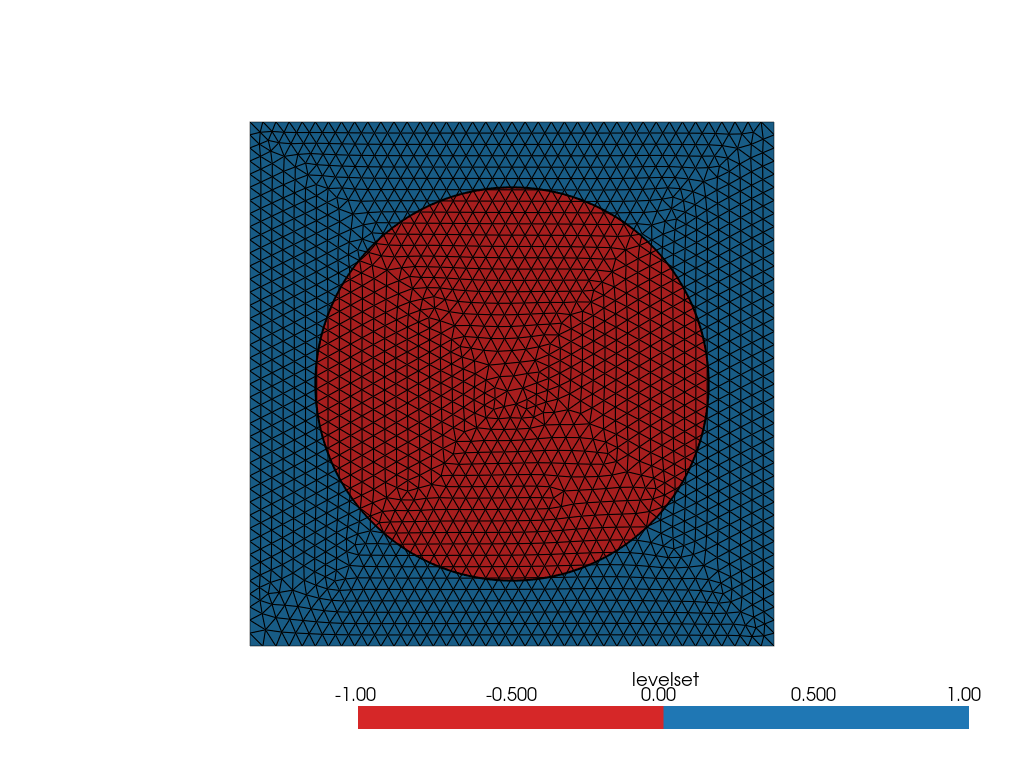

In [32]:
# pv.set_jupyter_backend('html')
vis = pv.read("levelset.vtu")


cont = vis.contour(isosurfaces=[0], scalars="levelset")
pl = pv.Plotter()
pl.add_mesh(vis, scalars="levelset",
            cmap=["#d62728", "#1f77b4"], clim=[-1,1],
            categories=True, show_edges=True)
pl.add_mesh(cont, color="black", line_width=2)
pl.camera_position = "xy"
pl.screenshot("levelset.png")
pl.close()
display(Image(filename="levelset.png"))
# pl.show(cpos="xy")

In [33]:
E_in,  nu_in  = 3.0, 0.30     # material A (levelset < 0)  — inside the circle
E_out, nu_out = 1.0, 0.20     # material B (levelset > 0)  — outside

# Lamé from (E, nu)
def lame_from_Enu(E, nu, plane_stress=False):
    mu = E/(2*(1+nu))
    lam = E*nu/((1+nu)*(1-2*nu))        # 3D Lamé
    lam_eff = (2*mu*nu/(1-nu)) if plane_stress else lam
    return mu, lam_eff

plane_stress = False
mu_in,  lam_eff_in  = lame_from_Enu(E_in,  nu_in,  plane_stress)
mu_out, lam_eff_out = lame_from_Enu(E_out, nu_out, plane_stress)


mu_cf       = IfPos(levelset, mu_out,      mu_in)
lam_eff_cf  = IfPos(levelset, lam_eff_out, lam_eff_in)

FE space (component-wise Dirichlet via a product space)

In [34]:
Vx = H1(mesh, order=2, dirichlet="left")     # only x-component fixed on 'left'
Vy = H1(mesh, order=2, dirichlet="bottom")   # only y-component fixed on 'bottom'
X  = Vx * Vy
(ux, uy), (vx, vy) = X.TnT()

Kinematics & constitutive law

In [35]:
def eps_2D(ux, uy):
    exx = grad(ux)[0]
    eyy = grad(uy)[1]
    exy = 0.5*(grad(ux)[1] + grad(uy)[0])
    return CoefficientFunction((exx, exy,
                                exy, eyy), dims=(2,2))

def sigma_2D(ux, uy):
    e  = eps_2D(ux, uy)
    tr = grad(ux)[0] + grad(uy)[1]
    return 2*mu_cf*e + lam_eff_cf*tr*Id(2)   # <- piecewise parameters


Forms: a(u,v) and f(v)

In [36]:
a = BilinearForm(X, symmetric=True)
a += InnerProduct(sigma_2D(ux, uy), eps_2D(vx, vy)) * dx

Uniform upward traction on the right edge (adjust as you like)

In [37]:
t = CoefficientFunction((1.0, 0.0))
f = LinearForm(X)
f += InnerProduct(t, CoefficientFunction((vx, vy))) * ds("right")

Solve

In [38]:
with TaskManager():
    a.Assemble(); f.Assemble()
    gfu = GridFunction(X)
    gfu.vec.data = a.mat.Inverse(X.FreeDofs()) * f.vec

Compute stress tensor and Von Mises stress for 2D (plane strain/stress)

In [39]:
uh = CoefficientFunction((gfu.components[0], gfu.components[1]))
s = sigma_2D(uh[0], uh[1])
von_mises = sqrt(s[0,0]**2 + s[1,1]**2 - s[0,0]*s[1,1] + 3*s[0,1]**2)

 Visualize displacement & Von Mises stress

In [40]:
uh = CoefficientFunction((gfu.components[0], gfu.components[1]))
norm_u = Norm(uh)
Draw(norm_u, mesh, "||u||")#, deformation=uh)
Draw(von_mises, mesh, "von Mises")#, deformation=uh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [41]:
vtk = VTKOutput(mesh, coefs=[norm_u, von_mises], names=["norm_u", "von_mises"], filename="elastic_lin").Do()

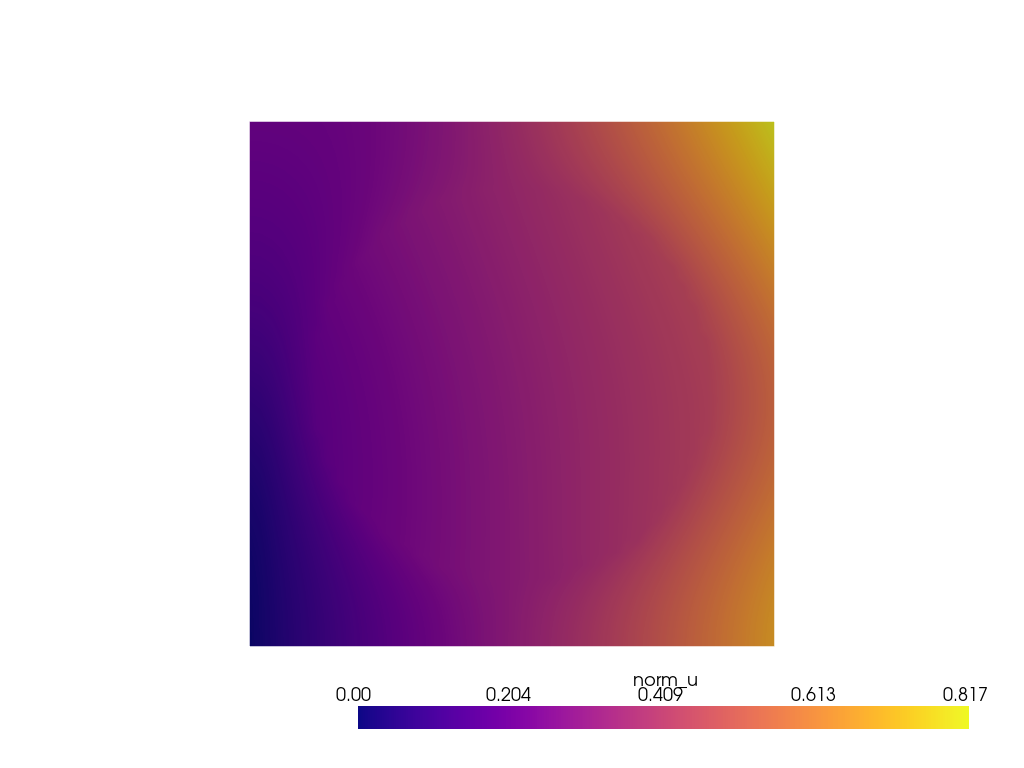

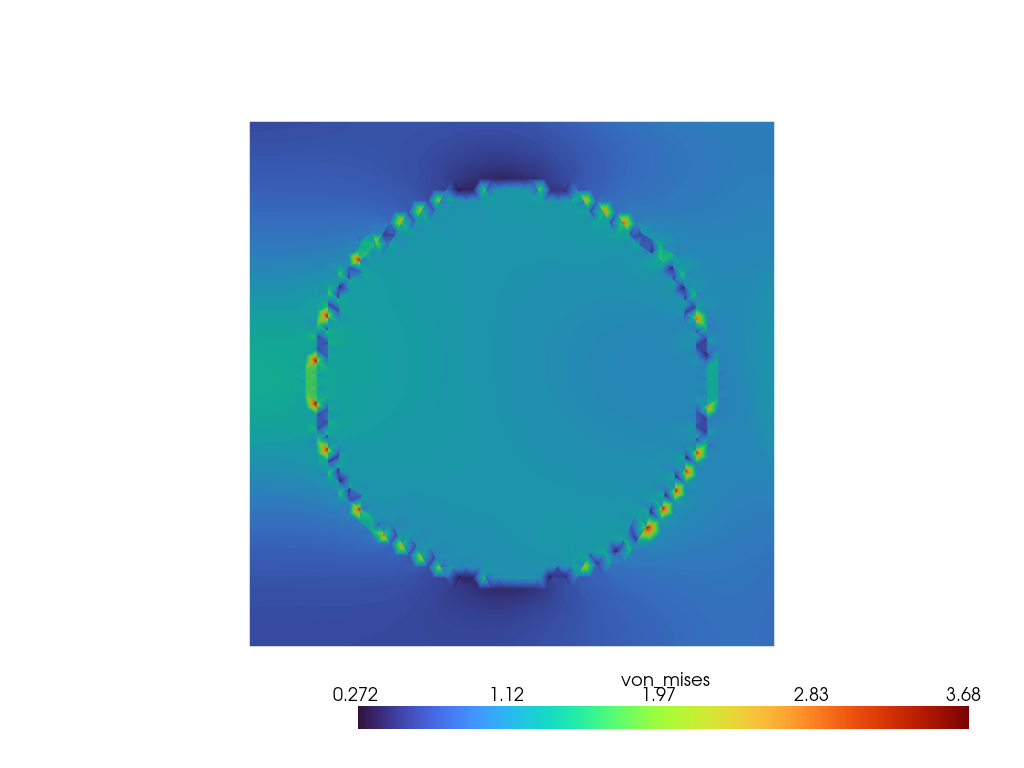

In [42]:
# pv.set_jupyter_backend('html')
visobj = pv.read("elastic_lin.vtu")

def save_png(field, filename, cmap="viridis"):
    pl = pv.Plotter(off_screen=True)
    pl.add_mesh(visobj, scalars=field, cmap=cmap, show_edges=False)
    pl.camera_position = "xy"
    pl.screenshot(filename)
    pl.close()

save_png("norm_u", "norm_u.png", cmap="plasma")
save_png("von_mises", "von_mises.png", cmap="turbo")

display(Image(filename="norm_u.png"))
display(Image(filename="von_mises.png"))